# Background
The objective of this project is to classify the overall sentiment of a tweet's context as neutral, negative, or positive using NLP classifiers. To complete, this project, we are given a dataset of 27,481 tweets, where 22,464 of those tweets were captured as having either a neutral, negative, or positive sentiment. Our goal is to use this training data of ~27.5k tweets to predict the sentiment of the 3,534 tweets in our testing data set.

## Import Libraries
Importing usual data analytics libraries:

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Importing text, pre-processing libraries:

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('popular')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valmh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\valmh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\valmh\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\valmh\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\valmh\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nl

Importing model-building libraries:

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

Importing bag of words libraries:

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Importing word embedding libraries:

In [5]:
import gensim
from gensim.models import Word2Vec

## Loading Dataset

In [6]:
train = pd.read_csv("C:/Users/valmh/Documents/GitHub/ENTITY-Final-Project/Data/train.csv")
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
test = pd.read_csv("C:/Users/valmh/Documents/GitHub/ENTITY-Final-Project/Data/test.csv")
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


## Exploratory Data Analysis

### Sentiment Distribution
The dataset is slightly imbalanced. There are more neutral sentiment tweets (11,118) than there are positive (8,582) or negative (7,781). However, the imbalance is not too much that there needs to be a data-balancing technique introduced.

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='sentiment'>

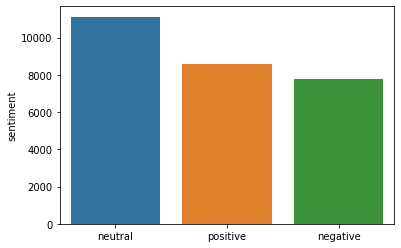

In [8]:
x = train['sentiment'].value_counts()
sns.barplot(x.index, x)

In [9]:
print(x)

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


### Missing Values
There is just 1 missing value in the text and selected_text columns. Assuming this is the same row, this row will be removed in the data wrangling step.

In [10]:
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

### Number of Words in a Tweet

In [11]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
print(train[train['sentiment']=='neutral']['word_count'].mean())
print(train[train['sentiment']=='positive']['word_count'].mean())
print(train[train['sentiment']=='negative']['word_count'].mean())

12.342867422198237
13.109881146585877
13.473203958360108


Tweets between positive, negative, and neutral sentiments all appear to have around the same number of words. Neutral tweets contain an average of 12.34 words, positive contain an average 13.11 of words, and negative tweets contain an average of 13.47 words.

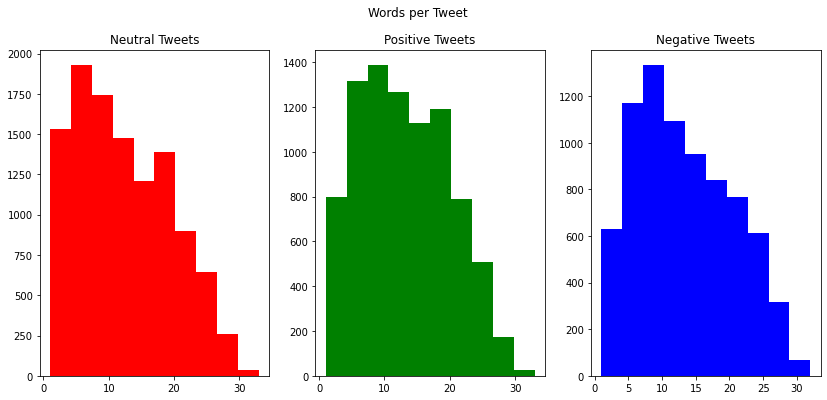

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,6))
train_words=train[train['sentiment']=='neutral']['word_count']
ax1.hist(train_words, color="red")
ax1.set_title('Neutral Tweets')
train_words=train[train['sentiment']=='positive']['word_count']
ax2.hist(train_words, color="green")
ax2.set_title('Positive Tweets')
train_words=train[train['sentiment']=='negative']['word_count']
ax3.hist(train_words, color="blue")
ax3.set_title('Negative Tweets')
fig.suptitle('Words per Tweet')
plt.show()

### Number of Characters in a Tweet
Neutral tweets contain an average of 65.20 characters, positive tweets contain an average of 70.42 characters, and negative tweets contain an average of 70.49 characters.

In [13]:
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
print(train[train['sentiment']=='neutral']['char_count'].mean())
print(train[train['sentiment']=='positive']['char_count'].mean())
print(train[train['sentiment']=='negative']['char_count'].mean())

65.20120525274329
70.41913306921464
70.4881120678576


## Data Wrangling/Text Pre-Processing

### Dropping ID column

In [14]:
train = train[['text','selected_text', 'sentiment']]

### Punctuation Removal Function

In [15]:
def removepunct(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

### Stopword Removal from Texts Function

In [16]:
def stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('english')]
    return ' '.join(a)

### Lemmatization Function
Lemmatization reduces a word to its base form by getting rid of its suffix

In [17]:
wl = WordNetLemmatizer()
def position(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatizer(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(text))
    a = [wl.lemmatize(tag[0], position(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return ' '.join(a)

### Combining Functions for Train & Test Data

In [18]:
def combined(text):
    return lemmatizer(stopword(removepunct(text)))

In [19]:
train['clean'] = train.text.astype(str).str.lower()
test['clean'] = test.text.astype(str).str.lower()

In [20]:
train['clean'] = train['clean'].apply(lambda x: combined(x))
test['clean'] = test['clean'].apply(lambda x: combined(x))

In [21]:
train.head()

,text,selected_text,sentiment,clean
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id respond go
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego
2,my boss is bullying me...,bullying me,negative,bos bully
3,what interview! leave me alone,leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put release already buy


In [22]:
test.head()

,textID,text,sentiment,clean
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session day httptwitpiccom67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai also really excite precisely skyscrap...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,httptwitpiccom4w75p like


### Tokenizing the Data

In [23]:
tokenizer = RegexpTokenizer('\w+')
train['tokens'] = train['clean'].apply(tokenizer.tokenize)

In [24]:
train.head()

,text,selected_text,sentiment,clean,tokens
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id respond go,"[id, respond, go]"
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,bullying me,negative,bos bully,"[bos, bully]"
3,what interview! leave me alone,leave me alone,negative,interview leave alone,"[interview, leave, alone]"
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put release already buy,"[son, couldnt, put, release, already, buy]"


## Embedding
Embedding is the process of converting text data to numerical data or vectors.

In [25]:
x_train = train['clean']
y_train = train['sentiment']
x_test = test['clean']
y_test = test['sentiment']

### Word2Vec

In [26]:
x_train_tok= [nltk.word_tokenize(i) for i in x_train]  
x_test_tok= [nltk.word_tokenize(i) for i in x_test]

### Bag of Words

In [27]:
train['clean_text_tok']=[nltk.word_tokenize(i) for i in train['clean']]
model = Word2Vec(train['clean_text_tok'],min_count=1) 

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
            return self
    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
                for words in X
            ])

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
x_train_vectors_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_vectors_tfidf = tfidf_vectorizer.transform(x_test)
    
model = Word2Vec(train['clean_text_tok'],min_count=1)     
modelw = MeanEmbeddingVectorizer(w2v)

x_train_vectors_w2v = modelw.transform(x_train_tok)
x_val_vectors_w2v = modelw.transform(x_test_tok)

In [28]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
x_train_vectors_tfidf = tfidf_vectorizer.fit_transform(x_train) 
x_test_vectors_tfidf = tfidf_vectorizer.transform(x_test)


## Naive Bayes Classifier

In [29]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(x_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(x_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
#fpr, tpr, thresholds = roc_curve(y_test, y_prob)
#roc_auc = auc(fpr, tpr)
#print('AUC:', roc_auc)

              precision    recall  f1-score   support

    negative       0.75      0.42      0.54      1001
     neutral       0.54      0.81      0.65      1430
    positive       0.77      0.56      0.65      1103

    accuracy                           0.62      3534
   macro avg       0.68      0.60      0.61      3534
weighted avg       0.67      0.62      0.62      3534

Confusion Matrix: [[ 418  549   34]
 [ 113 1161  156]
 [  28  454  621]]


In [30]:
#Pre-processing the new dataset
test['clean_text'] = test['text'].apply(lambda x: combined(x)) #preprocess the data
x_test=test['clean_text'] 
#converting words to numerical data using tf-idf
x_vector=tfidf_vectorizer.transform(x_test)
#use the best model to predict 'target' value for the new dataset 
y_predict = nb_tfidf.predict(x_vector)      
y_prob = nb_tfidf.predict_proba(x_vector)[:,1]
test['predict_prob']= y_prob
test['target']= y_predict
final=test[['clean_text','target','sentiment']].reset_index(drop=True)
print(final.head())

                                          clean_text    target sentiment
0               Last session day httptwitpiccom67ezh   neutral   neutral
1  Shanghai also really excite precisely skyscrap...  positive  positive
2  Recession hit Veronique Branquinho quit compan...  negative  negative
3                                         happy bday  positive  positive
4                         httptwitpiccom4w75p I like   neutral  positive


In [31]:
train.describe()

,text,selected_text,sentiment,clean,tokens,clean_text_tok
count,27480,27480,27481,27481,27481,27481
unique,27480,22463,3,26876,26876,26876
top,"I`d have responded, if I were going",good,neutral,,[],[]
freq,1,199,11118,54,54,54


In [32]:
from textblob import TextBlob

### Visualizing sentiment scores

<AxesSubplot:>

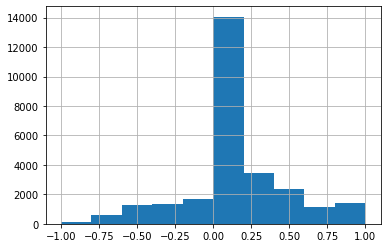

In [33]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

train2 = train['clean'].\
   apply(lambda x : polarity(x))
train2.hist()

<BarContainer object of 3 artists>

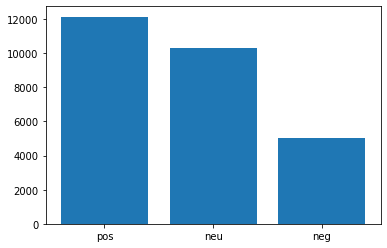

In [35]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
train2=train2.\
   map(lambda x: sentiment(x))

plt.bar(train2.value_counts().index,
        train2.value_counts())

## VADER Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\valmh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

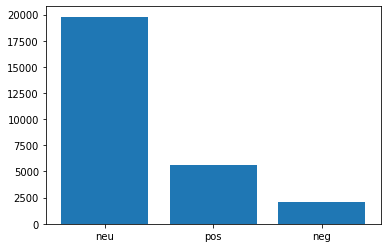

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

train2=train['clean'].\
    map(lambda x: get_vader_score(x))
polarity=train2.replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

In [38]:
from sklearn.model_selection import train_test_split
import torch
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

C:\Python3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [40]:
train.describe()

,text,selected_text,sentiment,clean,tokens,clean_text_tok
count,27480,27480,27481,27481,27481,27481
unique,27480,22463,3,26876,26876,26876
top,"I`d have responded, if I were going",good,neutral,,[],[]
freq,1,199,11118,54,54,54


In [41]:
train.head()

,text,selected_text,sentiment,clean,tokens,clean_text_tok
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id respond go,"[id, respond, go]","[id, respond, go]"
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,"[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,bullying me,negative,bos bully,"[bos, bully]","[bos, bully]"
3,what interview! leave me alone,leave me alone,negative,interview leave alone,"[interview, leave, alone]","[interview, leave, alone]"
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put release already buy,"[son, couldnt, put, release, already, buy]","[son, couldnt, put, release, already, buy]"


In [54]:
new_df = train[['selected_text', 'sentiment', 'clean']]

TypeError: 'function' object is not subscriptable

In [63]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [64]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.selected_text
        self.targets = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [65]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [66]:
model = RobertaClass()
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [67]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [68]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [69]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [70]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]


KeyError: 18108